<a href="https://colab.research.google.com/github/klouderm/DS6290_RMS/blob/main/Assignment3/assign_3_kylieLoudermilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

Copyright 2021-2023 Kylie Loudermilk (kylieloudermilk@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

#### Imports and inits

In [ ]:
!pip install interpret

In [ ]:
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting
import time
import datetime                                             # for timers
from sklearn.metrics import accuracy_score, f1_score
from interpret.perf import ROC
import random

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

### Define utility functions

#### Utility function to calculate confusion matrices by demographic group

In [ ]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

#### Utility function to calculate AIR

In [ ]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))


#### Utility function to select probability cutoff by F1

In [ ]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):

    """ Utility function for finding max. F1.
        Coupled to get_confusion_matrix() and air().
        Assumes 1 is the marker for class membership.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.

    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_

        f1_frame = f1_frame.append(row_dict, ignore_index=True)

    del temp_df

    return f1_frame

#### Start global timer

In [ ]:
tic = time.time()

In [ ]:
import io
from google.colab import files
from google.colab import drive
uploaded = files.upload() # upload training and test data
import pandas as pd
train = pd.read_csv(io.StringIO(uploaded['hmda_train_preprocessed.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['hmda_test_preprocessed.csv'].decode('utf-8')))
!pip install piml
from piml import Experiment
exp = Experiment()
#exp.data_loader(data=train)

In [ ]:
drive.mount('/drive', force_remount=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Mounted at /drive


#### Import data

In [ ]:
#data = pd.read_csv('../data/hmda_train_preprocessed.csv')
#test = pd.read_csv('../data/hmda_test_preprocessed.csv')
data=train

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Basic data exploration

#### Histograms

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

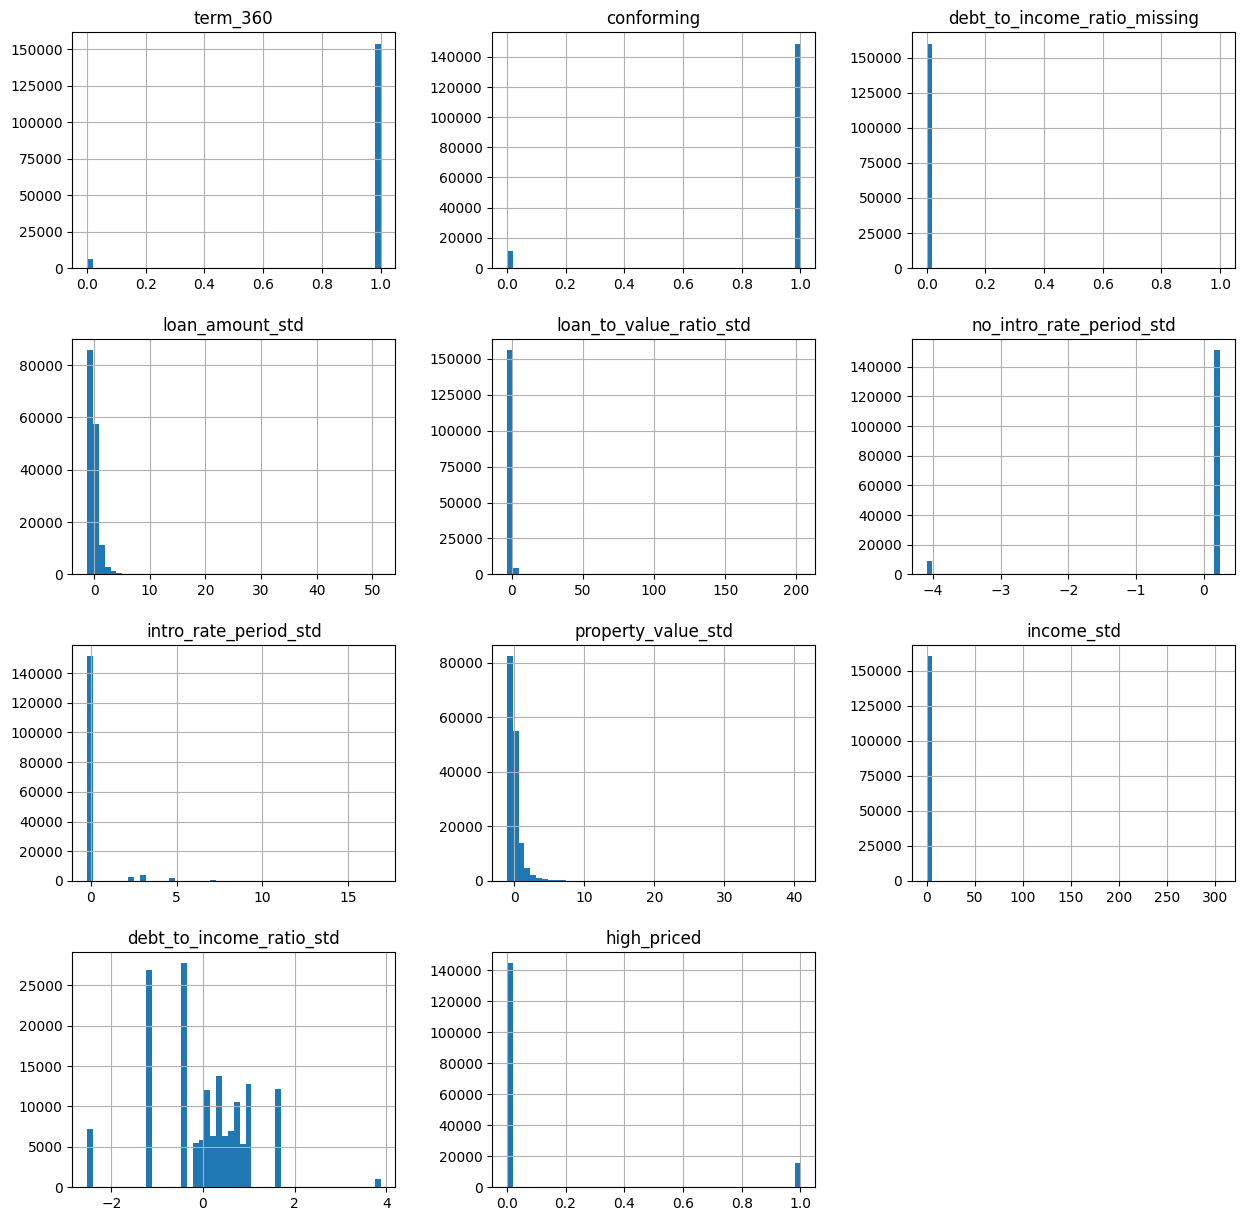

In [ ]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Correlations

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

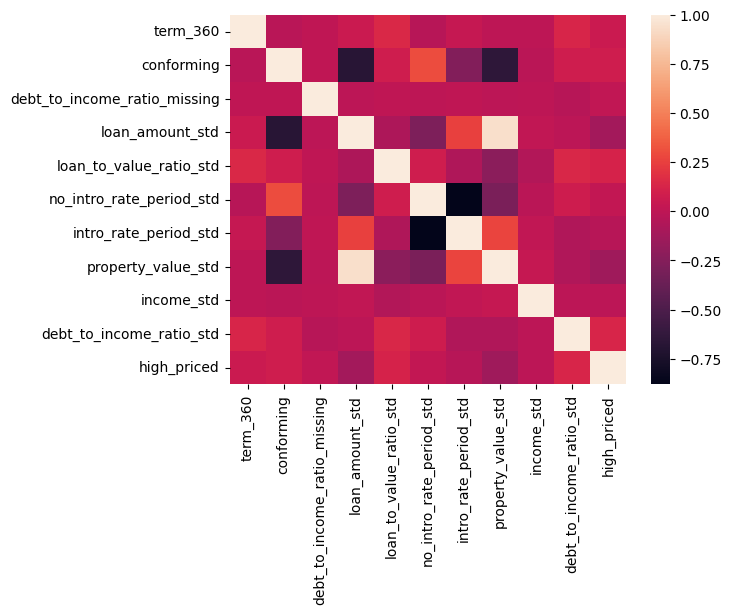

In [ ]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

## Fit interpretable models

#### Split data into train and validation partitions

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

exp.data_loader(data=train[x_names+[y_name]])
exp.data_prepare()

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,1.0,1.0,0.0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0.0
1,1.0,1.0,0.0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0.0
2,1.0,1.0,0.0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0.0
3,1.0,1.0,0.0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0.0
4,1.0,1.0,0.0,-0.338504,0.372784,0.244394,-0.215304,-0.412593,-0.024716,0.397554,0.0
...,...,...,...,...,...,...,...,...,...,...,...
112248,1.0,1.0,0.0,0.189165,-0.227057,0.244394,-0.215304,0.173267,-0.013628,-0.425131,0.0
112249,1.0,1.0,0.0,0.365054,0.663316,0.244394,-0.215304,0.019094,-0.015361,1.585876,0.0
112250,1.0,0.0,0.0,9.599253,-0.463082,-4.091747,2.197776,9.084518,0.270486,0.397554,0.0
112251,1.0,1.0,0.0,-0.998089,0.552520,0.244394,-0.215304,-0.905950,-0.039614,-0.425131,0.0


#### Utility function for random grid search

In [ ]:
def xgb2_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best XGB2 model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    xgb2_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)
    params = {'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    ctr = 0
    for i, exper in enumerate(selected_experiments):

        params.update(experiments[exper])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        modelName = f'REM_XGB2_{ctr}'
        #xgb2 = exp.model_train(model=XGB2Classifier(**params), name=modelName)
        xgb2 = XGB2Classifier(**params)
        ctr += 1

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = xgb2.fit(train[features].to_numpy(), train[y_name].to_numpy())

        # calculate AUC
        xgb2_perf = ROC(xgb2.predict_proba).explain_perf(valid[features].to_numpy(), valid[y_name].to_numpy())
        candidate_best_score = xgb2_perf._internal_obj['overall']['auc']
        # compose values to add to xgb2_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score

        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            del valid_phat

        # append run to xgb2_grid_frame
        xgb2_grid_frame = xgb2_grid_frame.append(row_dict, ignore_index=True)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_xgb2 = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del xgb2

    return best_xgb2, xgb2_grid_frame

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

### XGBoost Depth 2

Training XGBoost Depth 2 Model

In [ ]:
from piml.models import XGB2Classifier
exp.model_train(model=XGB2Classifier(), name='XGB_2')


# start local timer
mxgb2_tic = time.time()


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
exp.model_diagnose(model='XGB_2', show="accuracy_table", metric='AUC')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.9041,0.8262,0.0056,0.5926,0.0110
Test,0.8975,0.8212,0.0043,0.4545,0.0086
Gap,-0.0066,-0.0050,-0.0012,-0.1380,-0.0024


Generating predictions based on test data with XGBoost Depth 2 model

In [ ]:
XGB2preds = exp.experiment.registered_pipeline['XGB_2'].predict_proba(valid[x_names].values)[:, 1]
best_xgb2 = pd.DataFrame(XGB2preds, columns=['phat'])
best_xgb2 = pd.concat([valid.reset_index(drop=True), best_xgb2], axis=1)
best_xgb2

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.205579
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1,1,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.294507
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,1,1,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.026887
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,1.0,0.0,1,1,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.014627
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1,1,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48080,160322,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1,1,0,-0.646310,-0.140747,0.244394,-0.215304,-0.566767,-0.024023,-1.156406,0,0.025227
48081,160325,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.022983,0.031916,0,0.053469
48082,160327,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,1,0,-0.118642,0.405463,0.244394,-0.215304,-0.258419,0.013744,-1.156406,0,0.082781
48083,160328,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,1,1,0,0.496971,-0.248283,0.244394,-0.215304,0.450780,-0.023330,0.306144,0,0.006583


### Investigate Best Model (XGB2) for Discrimination

#### Find optimal cutoff based on F1
Cutoffs are normally selected by maximizing a quality statistic or a business metric, and not by considering bias and discrimination.

In [ ]:
f1_frame = get_max_f1_frame(best_xgb2, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.221080  0.335281
2    0.02  0.255481  0.457586
3    0.03  0.276002  0.518956
4    0.04  0.292229  0.562296
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3628 achieved at cutoff: 0.16 with accuracy: 0.7667.


#### Find confusion matrices for demographic groups

In [ ]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_xgb2, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       521      1059
predicted: 0       143      1469

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1       101       228
predicted: 0        47      2874

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2175      7284
predicted: 0       990     24076

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1174      3817
predicted: 0       490     10351

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       939      2627
predicted: 0       301      6165



#### Find AIR for Asian people

In [ ]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

White proportion accepted: 0.726
Asian proportion accepted: 0.899
Adverse impact ratio for Asian people vs. White people: 1.238


#### Find AIR for Black people

In [ ]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

White proportion accepted: 0.726
Black proportion accepted: 0.505
Adverse impact ratio for Black people vs. White people: 0.696


#### Find AIR for Females

In [ ]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Male proportion accepted: 0.685
Female proportion accepted: 0.645
Adverse impact ratio for Females vs. Males: 0.941


### Attempt remediation of discovered discrimination

#### Simplest remediation: Find cutoff with better Black vs. White AIR

In [ ]:
f1_frame = get_max_f1_frame(best_xgb2, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,cut,f1,acc,air
21,0.21,0.354926,0.825829,0.811950
22,0.22,0.349408,0.835583,0.833069
23,0.23,0.340714,0.846439,0.856137
24,0.24,0.325800,0.856691,0.876356
25,0.25,0.308607,0.867027,0.902442


Cutoffs in the 0.22-0.26 range provide increased accuracy and less bias towards Black people.

#### Check that other groups are not adversely impacted by change

In [ ]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_xgb2, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Adverse impact ratio for Asian people vs. White people: 1.123
Adverse impact ratio for Black people vs. White people: 0.833
Adverse impact ratio for Females vs. Males: 0.963


The new cutoff does not adversely affect other protected groups.

#### More sophisticated remdiation: Model selection via quality and fairness

In [ ]:
gs_params = {'n_estimators': [80, 100, 120],
             'max_bin': [20, 128, 256, 512],
             'eta': [0.2, 0.3, 0.4],
             'gamma': [0, 0.05, 0.1]}

# start local timer
xgb2_tic = time.time()

# new grid search that also considers AIR and fairness
best_xgb2, xgb2_grid_frame = xgb2_grid(train, best_xgb2, x_names, y_name, gs_params=gs_params, n_models=400, seed=SEED, air_reference='white', air_protected='black',
                                     air_cut=0.17)

# end local timer
xgb2_toc = time.time() - xgb2_tic
print('EBM training completed in %.2f s.' % (xgb2_toc))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

[{'n_estimators': 80, 'max_bin': 20, 'eta': 0.2, 'gamma': 0}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.2, 'gamma': 0.05}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.2, 'gamma': 0.1}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.3, 'gamma': 0}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.3, 'gamma': 0.05}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.3, 'gamma': 0.1}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.4, 'gamma': 0}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.4, 'gamma': 0.05}, {'n_estimators': 80, 'max_bin': 20, 'eta': 0.4, 'gamma': 0.1}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.2, 'gamma': 0}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.2, 'gamma': 0.05}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.2, 'gamma': 0.1}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.3, 'gamma': 0}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.3, 'gamma': 0.05}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.3, 'gamma': 0.1}, {'n_estimators': 80, 'max_bin': 128, 'eta': 0.4, 'gam

#### Display grid search results as table

In [ ]:
xgb2_grid_frame

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,n_estimators,max_bin,eta,gamma,features,auc,air,random_state
0,120,256,0.4,0.10,"[debt_to_income_ratio_missing, loan_amount_std...",0.822642,0.713076,12345.0
1,120,512,0.2,0.10,"[conforming, intro_rate_period_std, income_std...",0.700563,0.985092,12345.0
2,80,512,0.2,0.10,[debt_to_income_ratio_std],0.629422,0.902100,12345.0
3,80,20,0.2,0.05,[income_std],0.645980,0.999507,12345.0
4,100,20,0.2,0.00,"[loan_to_value_ratio_std, income_std]",0.765771,0.657283,12345.0
...,...,...,...,...,...,...,...,...
395,100,256,0.2,0.00,"[no_intro_rate_period_std, property_value_std]",0.711472,0.927594,12345.0
396,120,128,0.4,0.10,"[intro_rate_period_std, debt_to_income_ratio_s...",0.823956,0.718234,12345.0
397,100,128,0.3,0.10,"[loan_to_value_ratio_std, intro_rate_period_st...",0.775125,0.674211,12345.0
398,80,512,0.3,0.10,"[property_value_std, loan_amount_std, no_intro...",0.764514,0.789257,12345.0


#### Display grid search results as plot

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

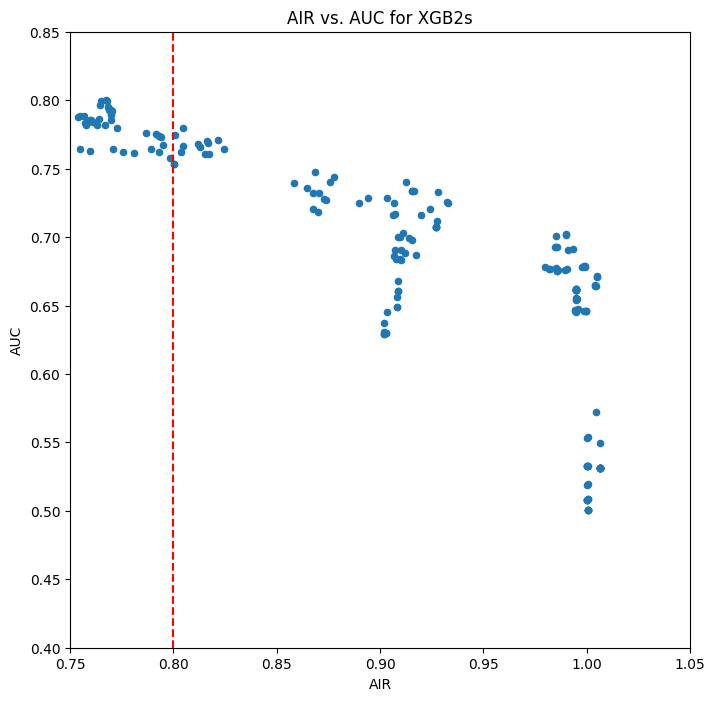

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
_ = xgb2_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for XGB2s', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

In [ ]:
# extract new params dict from xgb2_grid_frame
rem_params = xgb2_grid_frame.loc[xgb2_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])

# retrain
rem_xgb2 = XGB2Classifier(**rem_params)
rem_xgb2.fit(train[rem_x_names], train[y_name])
rem_xgb2_perf = ROC(rem_xgb2.predict_proba).explain_perf(valid[rem_x_names].to_numpy(), valid[y_name].to_numpy())
rem_auc = rem_xgb2_perf._internal_obj['overall']['auc']
print('Remediated XGB2 retrained with AUC: %.4f.' % rem_auc)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Best AUC: 0.7795 above 0.8 AIR (0.8045).
Remediated XGB2 retrained with AUC: 0.7795.


#### Check that other groups are not adversely impacted by change

In [ ]:
# create a frame with remediated EBM predictions
best_xgb2_phat2 = pd.DataFrame(rem_xgb2.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
best_xgb2_phat2 = pd.concat([valid.reset_index(drop=True), best_xgb2_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_xgb2_phat2, y_name, 'phat', by=name, level=1, cutoff=0.18, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Adverse impact ratio for Asian people vs. White people: 1.131
Adverse impact ratio for Black people vs. White people: 0.829
Adverse impact ratio for Females vs. Males: 0.964


This analysis shows that even with a selective cutoff of 0.17, less discriminatory models are available. The new set of features and hyperparameters leads to a ~11% increase in AIR with a ~5% decrease in AUC.

Retraining using PiML low code method

In [ ]:
exp.model_train(model=XGB2Classifier(**rem_params, feature_names=rem_x_names), name='REM_XGB2')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Compiling prdeictions using test data and exporting csv of phat results to google drive

In [ ]:
REM_XGB2preds = exp.experiment.registered_pipeline['REM_XGB2'].predict_proba(test[x_names].values)[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
best_rem_xgb2_submit = pd.DataFrame(REM_XGB2preds, columns=['phat'])
filename = '/drive/My Drive/Assignment3/kylieLoudermilk_best_rem_xgb2_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv')
best_rem_xgb2_submit.to_csv(filename,
                        index=False)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Print best model parameters for later use

In [ ]:
rem_params

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

{'n_estimators': 80,
 'max_bin': 20,
 'eta': 0.3,
 'gamma': 0.05,
 'random_state': 12345}

#### Print best model features for later use

In [ ]:
rem_x_names

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

['intro_rate_period_std',
 'debt_to_income_ratio_missing',
 'conforming',
 'no_intro_rate_period_std',
 'income_std',
 'debt_to_income_ratio_std',
 'property_value_std',
 'term_360']

#### End timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

All tasks completed in 3966.92 s.
